In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

## **Forecasting increasing complexity**

In [ ]:
def generate_ar_1(N, sigma, x0, phi_1, delta):
    
    x = np.zeros(N)
    w = np.random.normal(0, sigma, size=N)
    x[0] = x0

    for t in np.arange(1, N, 1):
        x[t] = delta + phi_1*x[t - 1] + w[t]
 
    x = pd.DataFrame({'t': np.arange(0, N, 1), 'x': x}).set_index('t')

    return x


def train_test_model(x, test_size, order, seasonal_order):
    test_size = 50
    x_train = x[:-test_size]
    x_test = x[-test_size:]

    model = SARIMAX(
        endog=x_train, 
        order=order, 
        seasonal_order=seasonal_order,
        trend='c'    
    )
    model_fit = model.fit()

    print(model_fit.summary())

    in_sample_prediction = model_fit.get_prediction(start=0, end=len(x_train) - 1)
    fitted_mean = in_sample_prediction.predicted_mean
    fitted_ci = in_sample_prediction.conf_int(alpha=0.1)

    long_run_forecasts = model_fit.get_forecast(steps=test_size)
    long_run_forecasts_mean = long_run_forecasts.predicted_mean
    long_run_forecasts_ci = long_run_forecasts.conf_int(alpha=0.1)

    # make rolling predictions on test data
    predictions_mean = list()
    predictions_ci_low = list()
    predictions_ci_high = list()
    for i in range(test_size):
        forecast = model_fit.get_forecast(steps=1)
        forecast_mean = forecast.predicted_mean.iloc[0]
        forecast_ci = forecast.conf_int(alpha=0.1)

        predictions_mean.append(forecast_mean)
        predictions_ci_low.append(forecast_ci.iloc[0, 0])
        predictions_ci_high.append(forecast_ci.iloc[0, 1])        
        model_fit = model_fit.append([x_test.iloc[i]]) # Update the model's internal state with the actual observation from the test set

    return {
        'x_train': x_train,
        'x_test': x_test,
        'model_fit': model_fit, 
        'fitted_mean': fitted_mean, 
        'fitted_ci': fitted_ci, 
        'predictions_mean': predictions_mean, 
        'predictions_ci_low': predictions_ci_low,
        'predictions_ci_high': predictions_ci_high,
        'long_run_forecasts_mean': long_run_forecasts_mean,
        'long_run_forecasts_ci': long_run_forecasts_ci,
    }


def plot(results):
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(2, 4)
    ax00 = fig.add_subplot(gs[0, :3])
    ax00.set_title('Residuals')
    ax00.plot(results['model_fit'].resid)
    ax00.axhline(y=0, linestyle='--', color='black')
    ax10 = fig.add_subplot(gs[1, :3])
    ax10.set_title('Modelling')
    ax10.plot(results['x_train'], label='train data')
    ax10.plot(results['fitted_mean'], color='red', label='fitted mean')
    ax10.fill_between(results['x_train'].index, results['fitted_ci'].iloc[:, 0], results['fitted_ci'].iloc[:, 1], color='red', alpha=0.2, label='fitted values ci')
    ax10.plot(results['x_test'], label='test data')
    ax10.plot(results['x_test'].index, results['predictions_mean'], color='green', label='rolling predictions')
    ax10.fill_between(results['x_test'].index, results['predictions_ci_low'], results['predictions_ci_high'], color='green', alpha=0.2, label='rolling predictions ci')
    ax10.plot(results['long_run_forecasts_mean'], color='black', label='long run forecast')
    ax01 = fig.add_subplot(gs[0, 3])
    ax11 = fig.add_subplot(gs[1, 3])
    ax10.legend(loc='upper center', ncol=7, fontsize='small', handlelength=0.5)
    sm.graphics.tsa.plot_acf(results['model_fit'].resid, ax=ax01)
    sm.graphics.tsa.plot_pacf(results['model_fit'].resid, ax=ax11)
    plt.tight_layout()
    plt.show()

### **Notes on how to interpret model quality**

- Forecasts (and also fitted values) represent the **expected value**<sup>*</sup> of the variable we're modelling, so they cannot be directly compared to the observed test datapoints because these represent individual realizations (random draws) of the random variable. It just doesn't make sense to expect that individual draws from a distribution **always** equal the distribution's expected value. If that happened, there'd be no need for statistics.

- Because of this, even with an accurate, well-specified model, there **will** be deviations between individual test datapoints and the forecasted mean. That's what residuals are! In this sense, residuals are not simply modelling error; they are **inherent** to modelling stochastic processes, and with a good model, they consist only of *irreducible* error.

- What we actually should expect is not for individual residuals but their **aggregate** (mean, median, root-mean-square, ...) to be close to zero. More specifically:
    - residuals should be **unbiased** -> mean, median, root-mean-square, etc. of residuals should be close to zero
    - residuals should be **homogeneous** -> no evidence of heteroskedasticity
    - residuals should be **uncorrelated** > no evicence of autocorrelation
    - $(1-\alpha)$ % (e.g., 95%) of the test datapoints should fall within $(1-\alpha)$ % confidence intervals around the forecasted expected values

If any of these fail, there's likely information left in the residuals that should be captured by the model, i.e., residuals not only contain irreducible but also reducible error, and that means the model is not well specified / well trained.

These points also apply in a purely predictive modelling context. Any model, however big/complex, yields **probabilistic** predictions, and is therefore subject to the above rules.

<font size="2"><sup>*</sup> Conditioned on the past and model parameters</font>

### **Synthetic AR(1), forecast with SARIMAX(1,0,0)(0,0,0)$_0$**

Autoregressive order-1 process, no moving average terms, no seasonality, no trend.

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                  150
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -423.926
Date:                Tue, 05 Nov 2024   AIC                            853.852
Time:                        11:40:34   BIC                            862.883
Sample:                             0   HQIC                           857.521
                                - 150                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.8294      0.351     -2.361      0.018      -1.518      -0.141
ar.L1          0.3836      0.080      4.769      0.000       0.226       0.541
sigma2        16.6665      2.045      8.149      0.0

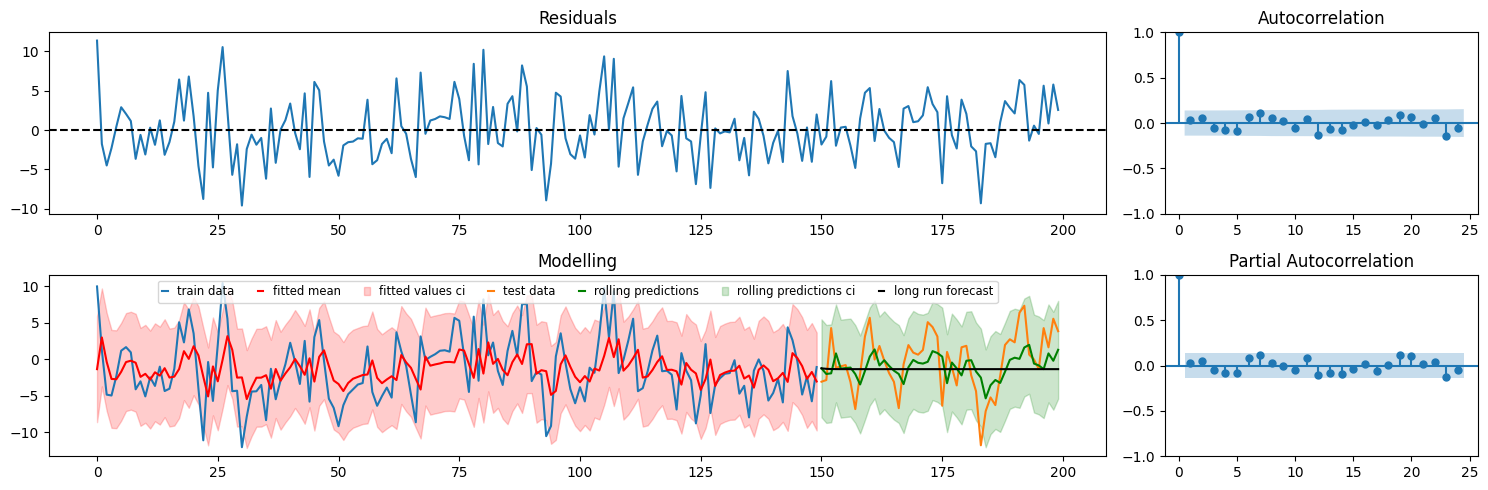

In [6]:
x = generate_ar_1(N=200, sigma=4, x0=10, phi_1=0.45, delta=0)
results = train_test_model(x, test_size=50, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
plot(results)

##### **Results**

- Summary indicates the AR(1) model **does** capture the structure of the underlying AR(1) process. Parameter estimates are close to actual values, no autocorrelation in residuals, residuals are normally distributed, no evidence of heterosckedasticity. Most test datapoints fall within the 95% prediction intervals.

- Long-run forecast in AR(1) model flattens out and stabilizes at the expected value of the AR(1) process. This happens because forecasts (out-of-sample predictions) in an AR(1) model can be written as $\hat{x}_{t+h} = \delta\sum_{k=0}^{k=h-1}\phi^k + \phi^hx_t = \delta\frac{1-\phi^h}{1-\phi} + \phi^hx_t$, and this expression tends to $\hat{x}_{t+h} = \frac{\delta}{1-\phi}$ as $h \to \infty$ (assuming stationarity).

- Rolling forecasts are more variable, simply because we use the obvserved test datapoints, which are more variable than their mean.

- Forecasts lag behind whenever there are sharp changes in the data because there's nothing in the model that can allow it to anticipate those changes. The model always needs a few time steps to catch up.

### **Synthetic MA(1), forecast with SARIMAX(0,0,1)(0,0,0)$_0$**


2. synthetic ma(1), forecast with sarimax(0,0,1)(0,0,0,0), explain difference to ar(1) check resid autocorr, normality, homosckedast., forecast quality
3. add trend to ar(1), forecast with sarimax(1,1,0)(0,0,0,0), check resid autocorr, normality, homosckedast., forecast quality
4. add regular seasonality to ar(1), forecast with sarimax(1,0,0)(1,0,0,s), check resid autocorr, normality, homosckedast., forecast quality
5. what happens when seasonality becomes irregular? -> sunspot dataset